In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.metrics import f1_score
import cvxopt
import warnings

import os
os.chdir("/home/prats/Final")

In [2]:
# All constants goes here
cv = 5 # cross validation
kernels = ['linear', 'rbf', 'poly']
warnings.filterwarnings('ignore')

In [3]:
def crossval_score(clf, X, t, cv = 4):
    score = np.array([])
    n = X.shape[0]
    batch_size = n//cv
    for i in range(cv):
        beg, end = i*batch_size, (i+1)*batch_size
        test_X, test_t = X[beg:end,:], t[beg:end]
        train_X, train_t = np.delete(X, range(beg, end), axis = 0), np.delete(t, range(beg, end))
        clf.fit(train_X, train_t)
        predicted_t = clf.predict(test_X)
        f1 = f1_score(test_t, predicted_t, average='weighted')
        score = np.append(score, f1)
    return score

In [4]:
def plotVariations(kernel, cr, gr, dr, cvscores, tscores):
    if (kernel == 'linear'):
        # Variation with C only
        plt.plot(cr, cvscores, label='cross-validation')
        plt.plot(cr, tscores, label='training')
        plt.xlabel('C')
        plt.ylabel('Accuracy')
        plt.xscale('log')
        plt.title('Accuracy v/s C')
        plt.legend(loc='best')
        plt.show()
    elif (kernel == 'rbf' or kernel == 'sigmoid'):
        # Variation with C and gamma
        gr, cr = np.meshgrid(gr, cr)
        cvscores = cvscores.reshape(cr.shape)
        fig, ax = plt.subplots()
        cs = ax.contourf(cr, gr, cvscores)
        cbar = fig.colorbar(cs)
        plt.xlabel('C')
        plt.ylabel('gamma')
        plt.title('Contour plot for Accuracy v/s C and gamma (cross-validation)')
        plt.xscale('log')
        plt.yscale('log')
        plt.show()
        # training
        tscores = tscores.reshape(cr.shape)
        fig, ax = plt.subplots()
        cs = ax.contourf(cr, gr, tscores)
        cbar = fig.colorbar(cs)
        plt.xlabel('C')
        plt.ylabel('gamma')
        plt.title('Contour plot for Accuracy v/s C and gamma (training)')
        plt.xscale('log')
        plt.yscale('log')
        plt.show()
    else:
        # Variation with C, gamma and degree - poly kernals
        gr, cr = np.meshgrid(gr, cr)
        for d in dr:
            cvscores[d] = cvscores[d].reshape(cr.shape)
            fig, ax = plt.subplots()
            cs = ax.contourf(cr, gr, cvscores[d])
            cbar = fig.colorbar(cs)
            plt.xlabel('C')
            plt.ylabel('gamma')
            plt.title('Contour plot for Accuracy v/s C and gamma, degree=%i (cross-validation)'%(d))
            plt.xscale('log')
            plt.yscale('log')
            plt.show()
            # training
            tscores[d] = tscores[d].reshape(cr.shape)
            fig, ax = plt.subplots()
            cs = ax.contourf(cr, gr, tscores[d])
            cbar = fig.colorbar(cs)
            plt.xlabel('C')
            plt.ylabel('gamma')
            plt.title('Contour plot for Accuracy v/s C and gamma, degree=%i (training)'%(d))
            plt.xscale('log')
            plt.yscale('log')
            plt.show()

In [5]:
def findParameters(kernels, X, t, cr = np.logspace(0, 1, 10), gr = np.logspace(0, 1, 10), dr = range(1, 5), op = False):
    # returns the classifier with the best parameters
    best_score = np.array([-1])
    for kernel in kernels:
        if (kernel == 'poly'):
            cnt=0
            allscores = {}
            tscores = {}
            for d in dr:
                allscores[d] = np.array([])
                tscores[d] = np.array([])
        else:
            allscores = np.array([])
            tscores = np.array([])
        if (op):
            print('Kernel = %s' % (kernel))
        for c in cr:
            g2 = False
            for g in gr:
                if (g2 and kernel == 'linear'):
                    break
                g2 = True
                d2 = False
                for d in dr:
                    if (d2 and kernel != 'poly'):
                        break
                    d2 = True
                    clf = svm.SVC(kernel = kernel, C = c, gamma = g, degree = d)
                    score = crossval_score(clf, X, t, cv = cv)
                    if (kernel == 'poly'):
                        allscores[d] = np.append(allscores[d], score.mean())
                        tscores[d] = np.append(tscores[d], clf.fit(X, t).score(X, t))
                    else:
                        allscores = np.append(allscores, score.mean())
                        tscores = np.append(tscores, clf.fit(X, t).score(X, t))
                    if (op):
                        print('c = %0.4f, g = %0.4f, d = %i, score = %0.4f (+/- %0.4f)'%(c, g, d, score.mean(), 2*score.std()))
                    if (score.mean() > best_score.mean()):
                        best_score = score
                        best_clf = clf
        plotVariations(kernel, cr, gr, dr, allscores, tscores)
    return best_clf.fit(X, t), best_score

In [6]:
# The classifier using cvxopt
class mysvm:
    def __init__(this, kernel='rbf', C=1.0, gamma=1.0, degree=3, coef0=0.0, threshold=1e-5):
        this.kernel = kernel
        this.C = C
        this.gamma = gamma
        this.degree = degree
        this.coef0 = coef0
        this.threshold = threshold
    
    def buildK(this, X1, X2):
        K = X1.dot(X2.T)
        if (this.kernel == 'poly'):
            K = (this.gamma * K + this.coef0)**this.degree
        elif (this.kernel == 'sigmoid'):
            K = np.tanh(this.gamma * K + this.coef0)
        elif (this.kernel == 'rbf'):
            sq1 = np.diag(X1.dot(X1.T)).reshape((-1, 1))*np.ones((1, X2.shape[0]))
            sq2 = np.diag(X2.dot(X2.T)).reshape((1, -1))*np.ones((X1.shape[0], 1))
            K = 2*K-sq1-sq2
            K = np.exp(this.gamma * K)
        # All other kernels are treated to be linear
        this.K = K
    
    def fit(this, X, t):
        this.N = X.shape[0]
        this.buildK(X, X)
        t = t.reshape((-1, 1)) * 1.0
        P = cvxopt.matrix((t.dot(t.T))*this.K)
        q = cvxopt.matrix(-np.ones((this.N, 1)))
        G = cvxopt.matrix(np.concatenate((-np.eye(this.N), np.eye(this.N))))
        h = cvxopt.matrix(np.concatenate((np.zeros((this.N, 1)), this.C * np.ones((this.N, 1)))))
        A = cvxopt.matrix(t.T)
        b = cvxopt.matrix(0.0)
        
        cvxopt.solvers.options['show_progress'] = False
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        
        mu = np.array(sol['x']) # The lagrange multipliers
        this.sv_idx = np.where(mu > this.threshold)[0] # indices of all the support vectors
        
        # Extract the support vectors
        this.sx = X[this.sv_idx,:]
        this.st = t[this.sv_idx]
        this.mu = mu[this.sv_idx]
        
        this.b = np.sum(this.st)
        for j in this.sv_idx:
            this.b -= np.sum(this.mu * this.st * (this.K[j, this.sv_idx].reshape((-1, 1))))
        this.b /= this.sv_idx.shape[0]
        
        # Make the classifier
        def predict(X):
            this.buildK(this.sx, X)
            this.y = np.zeros((X.shape[0],))
            for i in range(this.y.shape[0]):
                this.y[i] = np.sum(this.mu * this.st * this.K[:,i].reshape((-1, 1)))+this.b
            return np.sign(this.y)
        
        this.predict = predict    

In [7]:
# All data is read here
data = np.array(pd.read_csv('2017EE10938.csv', header = None))
X = data[:, 0:-1]
t = data[:, -1].astype('int')
scl_p1 = max(X.max(), -X.min())
X = X/scl_p1

train_data = np.array(pd.read_csv('train_set.csv', header = None))
train_X = train_data[:, 0:-1]
train_t = train_data[:, -1].astype('int')
scl_p2 = max(train_X.max(), -train_X.min())
train_X = train_X/scl_p2

prediction_data = np.array(pd.read_csv('test_set.csv', header = None))
prediction_X = prediction_data[:,:]
prediction_X = prediction_X/scl_p2

Pair: (0, 1)
Kernel: linear


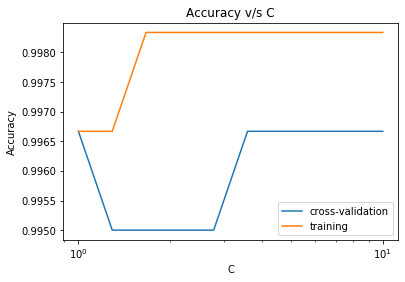

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 1.0, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
sklearn cross-val score: 0.9967, cvxopt cross-val score: 0.9950
sklearn num of SV: 32, cvxopt num of SV: 33
sklearn indices of support vector: [ 12  50  76 129 175 181 200 213 221 249 256 270 284 288 359 364 368 380
 409 411 434 449 475 477 495 526 527 528 551 566 582 594]
cvxopt indices of support vector : [ 12  50  76  95 129 175 181 200 213 221 249 256 270 284 288 359 364 368
 380 409 411 434 449 475 477 495 526 527 528 551 566 582 594]
Kernel: rbf


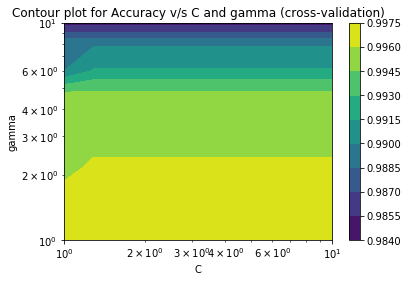

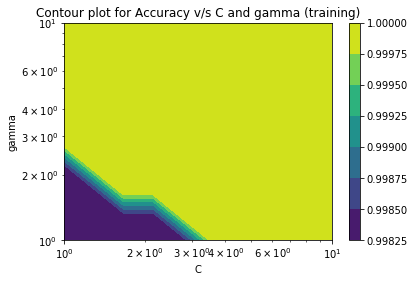

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 1.0, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
sklearn cross-val score: 0.9967, cvxopt cross-val score: 0.9967
sklearn num of SV: 39, cvxopt num of SV: 40
sklearn indices of support vector: [ 12  39  50  75  76  87 129 157 175 179 181 213 221 249 256 270 284 288
 356 359 364 368 380 409 411 434 449 475 477 486 526 527 528 529 551 566
 582 587 594]
cvxopt indices of support vector : [ 12  39  50  75  76  87 129 157 175 179 181 213 221 249 256 270 284 288
 356 359 364 368 380 407 409 411 434 449 475 477 486 526 527 528 529 551
 566 582 587 594]
Kernel: poly


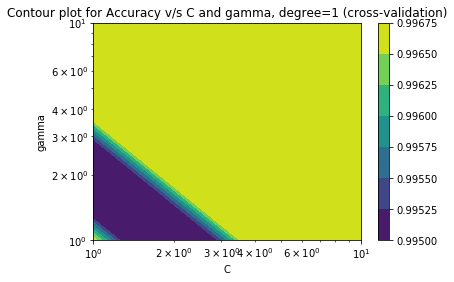

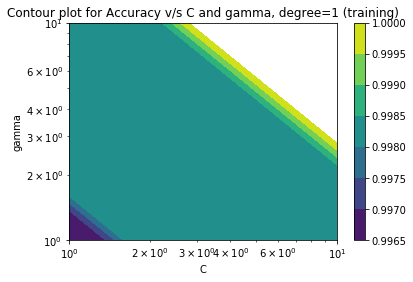

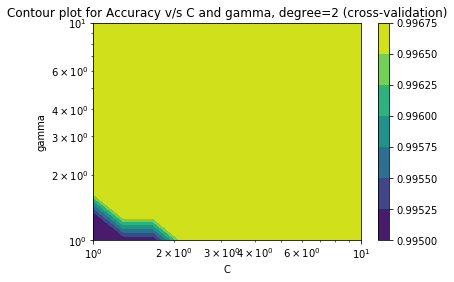

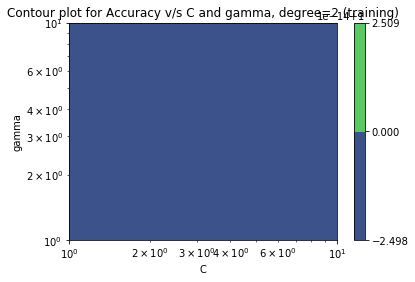

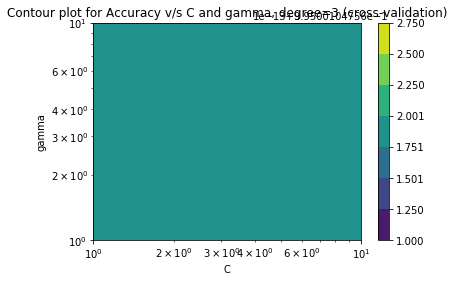

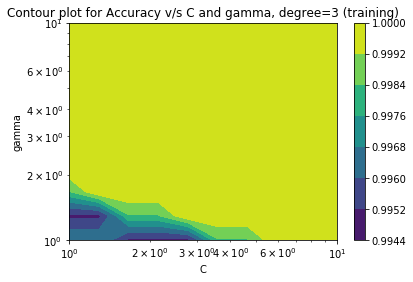

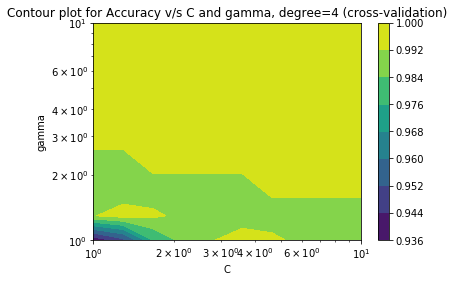

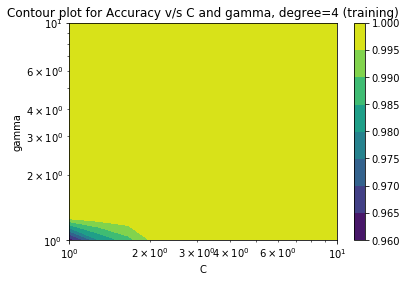

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 2, 'gamma': 1.6681005372000588, 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
sklearn cross-val score: 0.9967, cvxopt cross-val score: 0.9967
sklearn num of SV: 75, cvxopt num of SV: 77
sklearn indices of support vector: [  6  12  14  37  38  39  50  68  69  76  82  87 105 129 130 157 164 166
 170 172 175 179 181 198 200 204 213 221 222 245 256 270 279 284 288 297
 338 345 346 356 359 364 368 380 382 404 407 409 411 433 434 436 437 440
 453 466 471 472 475 486 496 521 526 527 528 529 548 551 564 566 569 582
 587 589 599]
cvxopt indices of support vector : [  6  12  14  37  38  39  50  68  69  76  82  87 105 129 130 157 164 166
 170 172 175 179 181 198 200 204 213 221 222 242 245 256 270 279 284 288
 297 338 345 346 356 359 364 368 380 382 404 407 409 411 433 434 436 437
 440 453 458 466 471 472 4

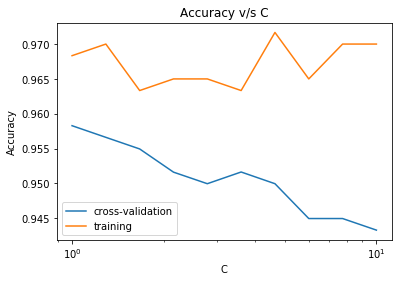

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 1.0, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
sklearn cross-val score: 0.9583, cvxopt cross-val score: 0.9583
sklearn num of SV: 140, cvxopt num of SV: 142
sklearn indices of support vector: [  2   3   4   5  10  12  22  26  28  30  43  49  51  52  55  58  62  68
  70  71  72  76  80  87 101 102 107 108 114 116 122 124 127 133 149 150
 166 171 173 177 188 190 191 195 196 197 199 200 202 218 219 222 224 237
 240 241 247 252 253 258 269 274 282 286 296 297 304 307 309 311 316 318
 328 333 334 339 341 344 354 359 362 363 364 366 370 375 376 384 387 398
 399 400 405 406 409 419 424 437 439 440 447 448 453 459 467 470 471 472
 474 478 480 493 495 501 504 507 514 521 522 524 528 534 535 536 539 542
 549 550 558 559 568 571 574 575 577 578 579 587 588 590]
cvxopt indices of support ve

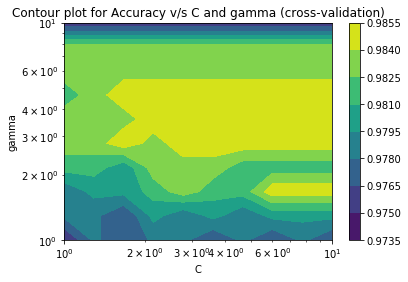

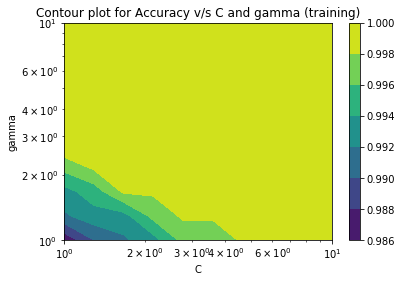

{'C': 2.7825594022071245, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 2.7825594022071245, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
sklearn cross-val score: 0.9850, cvxopt cross-val score: 0.9850
sklearn num of SV: 183, cvxopt num of SV: 187
sklearn indices of support vector: [  2   3   4   5   8  11  12  16  22  26  28  30  33  34  43  45  49  51
  52  54  55  58  60  62  63  65  70  71  72  73  80  82  86  88 101 102
 107 108 114 115 116 122 124 126 129 132 133 140 144 145 151 153 163 166
 168 173 177 181 184 188 190 194 195 196 199 200 202 207 214 219 220 222
 224 227 228 229 236 237 240 241 252 253 258 269 282 283 286 290 304 307
 309 311 316 318 322 324 328 333 334 339 341 342 344 351 354 359 362 363
 364 370 374 376 377 382 384 385 387 391 395 398 399 400 406 409 417 419
 420 422 427 435 439 440 448 456 459 467 469 470 471 472 47

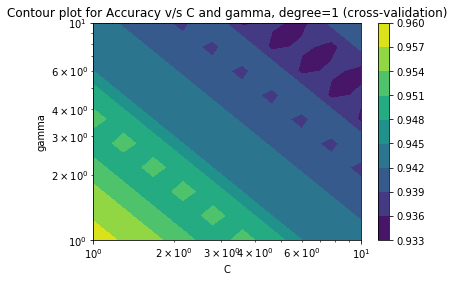

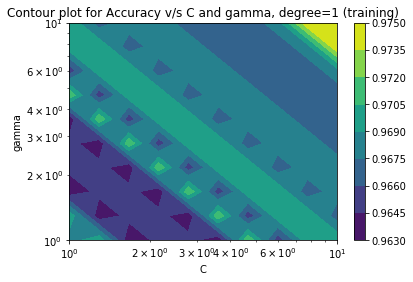

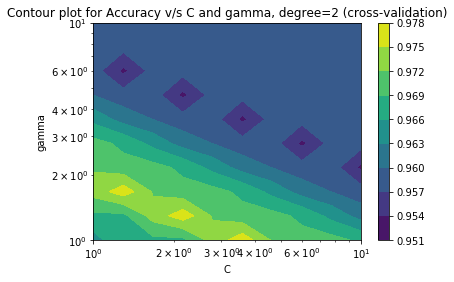

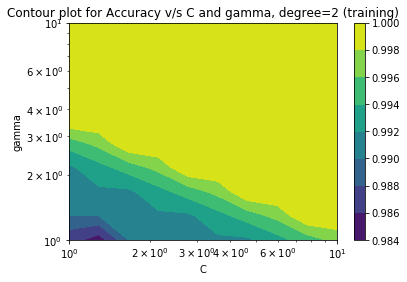

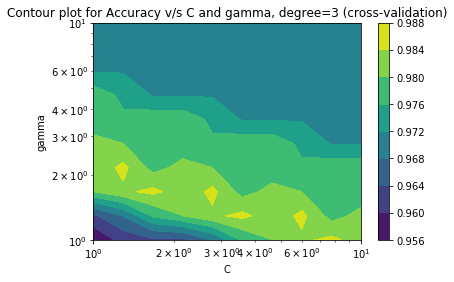

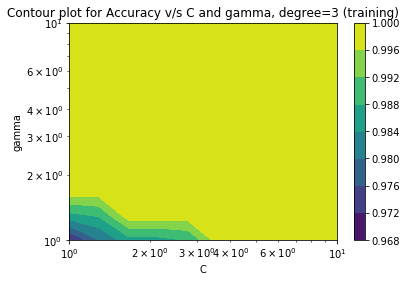

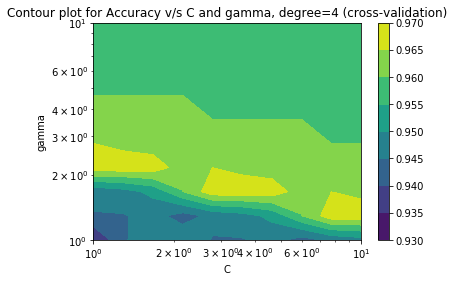

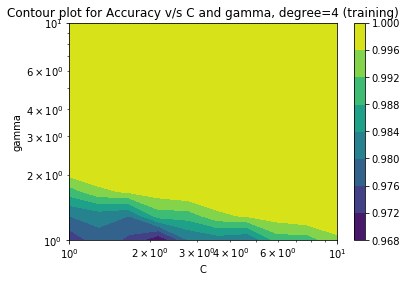

{'C': 1.6681005372000588, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1.6681005372000588, 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
sklearn cross-val score: 0.9850, cvxopt cross-val score: 0.9817
sklearn num of SV: 204, cvxopt num of SV: 208
sklearn indices of support vector: [  2   3   4   7  10  12  17  18  20  22  26  28  30  36  42  43  45  49
  50  51  52  54  55  56  58  62  63  65  66  68  71  72  73  80  82  86
  87  88  99 100 101 102 106 107 108 114 115 116 117 120 122 126 127 128
 129 132 137 140 143 144 149 153 160 163 166 177 181 184 188 190 193 195
 196 197 199 200 202 215 218 219 221 222 224 226 228 236 237 240 241 245
 246 247 252 253 258 259 263 269 276 279 286 290 292 296 300 301 307 309
 311 316 318 328 333 334 336 339 342 343 344 348 354 356 359 362 363 364
 366 370 371 374 375 376 377 382 387 394 398 400 406 409 4

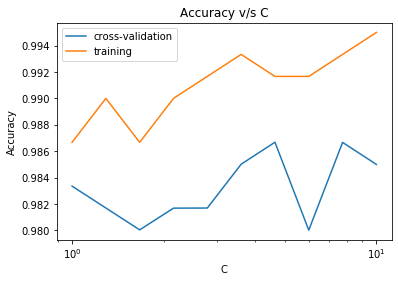

{'C': 4.641588833612778, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 1.0, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
sklearn cross-val score: 0.9867, cvxopt cross-val score: 0.9850
sklearn num of SV: 66, cvxopt num of SV: 68
sklearn indices of support vector: [ 14  23  36  86  88  89 119 122 123 127 138 140 154 155 160 173 222 234
 244 245 252 258 275 282 287 289 301 323 324 326 342 352 353 363 369 372
 379 385 387 391 403 411 417 429 432 439 448 455 456 458 464 465 472 481
 488 495 499 510 514 535 569 574 575 582 586 587]
cvxopt indices of support vector : [ 14  23  36  86  88  89 119 122 123 127 138 140 154 155 160 173 222 234
 244 245 252 258 275 282 287 289 301 323 324 326 342 352 353 363 369 372
 379 385 387 391 403 411 417 429 432 439 448 455 456 458 464 465 472 481
 488 495 499 510 514 535 563 564 569 574 575 582 586 587]
Kern

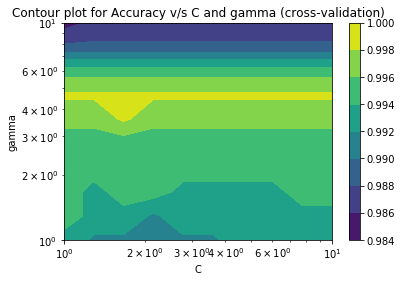

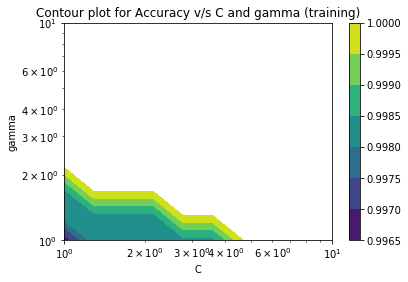

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 4.641588833612778, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
sklearn cross-val score: 0.9983, cvxopt cross-val score: 0.9983
sklearn num of SV: 269, cvxopt num of SV: 270
sklearn indices of support vector: [  0   1   6   9  11  14  16  17  18  21  22  25  26  34  36  37  38  41
  42  43  45  46  49  50  55  56  57  60  62  63  64  68  69  70  71  72
  73  75  79  80  81  82  86  87  88  89  95  96  98 101 102 110 111 119
 122 125 126 127 129 130 132 133 140 146 147 148 149 154 155 159 160 162
 166 168 171 173 178 179 181 182 184 191 198 199 203 207 208 209 212 215
 216 221 222 226 228 229 230 231 234 235 239 244 245 251 252 254 255 258
 263 267 269 272 274 275 276 278 279 280 281 284 287 289 290 292 294 298
 300 301 304 306 307 310 316 317 318 320 322 323 324 326 327 330 334 340
 3

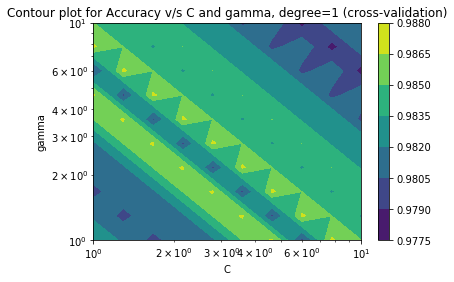

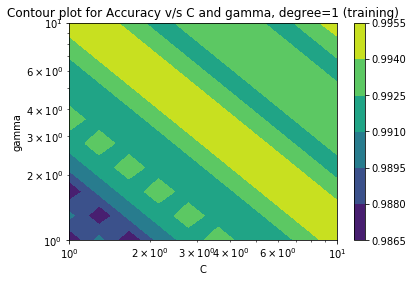

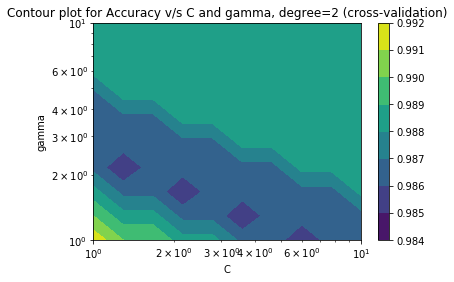

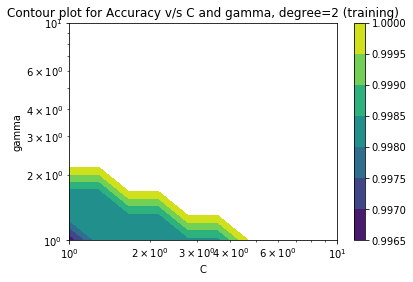

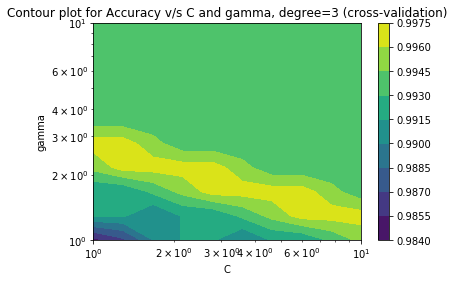

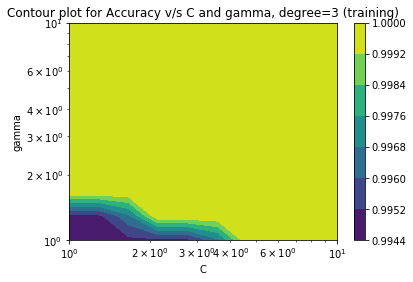

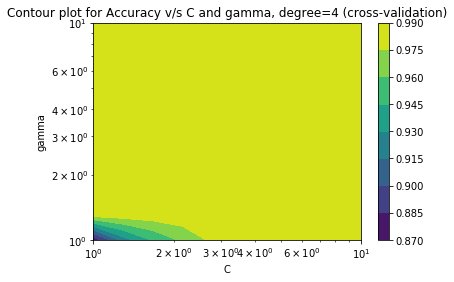

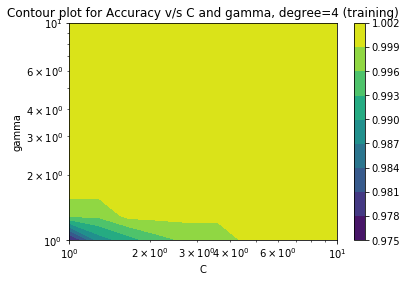

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 2.7825594022071245, 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
sklearn cross-val score: 0.9967, cvxopt cross-val score: 0.9967
sklearn num of SV: 169, cvxopt num of SV: 174
sklearn indices of support vector: [  3   4   6  14  18  21  25  28  31  32  34  35  37  50  57  58  60  63
  64  68  70  71  72  82  85  86  88  89  96  98 105 110 116 119 122 127
 130 140 141 149 154 155 160 162 166 173 178 182 191 194 200 203 205 212
 215 221 222 223 224 227 230 235 236 239 240 245 246 252 255 256 259 267
 268 269 272 275 286 287 289 290 294 301 306 317 319 322 323 324 326 330
 336 342 352 353 358 361 363 368 372 373 378 379 385 387 388 391 395 404
 406 407 411 415 417 418 423 424 426 429 430 432 438 439 440 448 455 456
 462 464 465 466 473 479 481 488 490 492 494 495 497 499 507 514 519 522


In [8]:
# Part 1 (Binary Classification) using all 25 features
pairs = [(0, 1), (2, 3), (4, 5)]
for i, j in pairs:
    print('Pair: (%i, %i)'%(i, j))
    idx_i = np.where(t == i)[0]
    idx_j = np.where(t == j)[0]
    idx = np.concatenate((idx_i, idx_j))
    np.random.shuffle(idx)
    Xp = X[idx,:]
    tp = t[idx]
    tp = np.where(tp==i, -1, 1)
    for kernel in kernels:
        print('Kernel: %s'%(kernel))
        clf_p, cvscore_p = findParameters([kernel], Xp, tp)
        param_p = clf_p.get_params()
        myclf = mysvm(kernel=kernel, C=param_p['C'], gamma=param_p['gamma'], degree=param_p['degree'], coef0=param_p['coef0'])
        mycvscore = crossval_score(myclf, Xp, tp, cv = cv)
        myclf.fit(Xp, tp)
        print(param_p)
        print('sklearn cross-val score: %0.4f, cvxopt cross-val score: %0.4f'%(cvscore_p.mean(), mycvscore.mean()))
        print('sklearn num of SV: %i, cvxopt num of SV: %i'%(clf_p.support_.shape[0], myclf.sv_idx.shape[0]))
        print('sklearn indices of support vector:', np.sort(clf_p.support_))
        print('cvxopt indices of support vector :', myclf.sv_idx)
    print('\n')

Pair: (0, 1)
Kernel: linear


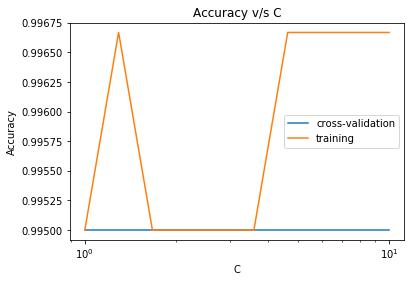

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 1.0, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
sklearn cross-val score: 0.9950, cvxopt cross-val score: 0.9950
sklearn num of SV: 38, cvxopt num of SV: 38
sklearn indices of support vector: [  2  62  88  93 117 120 153 165 175 197 208 211 216 255 265 282 289 297
 338 349 354 376 403 418 419 443 460 461 471 494 525 535 542 544 553 555
 573 581]
cvxopt indices of support vector : [  2  62  88  93 117 120 153 165 175 197 208 211 216 255 265 282 289 297
 338 349 354 376 403 418 419 443 460 461 471 494 525 535 542 544 553 555
 573 581]
Kernel: rbf


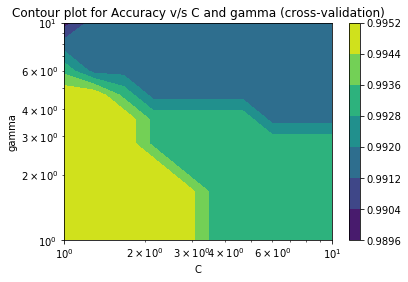

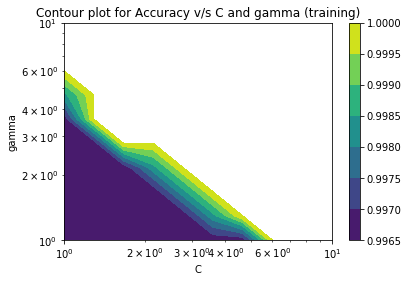

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 1.0, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
sklearn cross-val score: 0.9950, cvxopt cross-val score: 0.9950
sklearn num of SV: 33, cvxopt num of SV: 34
sklearn indices of support vector: [  2  26  62  88  93 117 153 171 175 197 208 211 216 275 282 289 297 349
 354 380 403 443 450 461 471 494 535 542 553 555 566 573 581]
cvxopt indices of support vector : [  2  26  62  88  93 117 153 171 175 197 208 211 216 275 282 289 297 349
 354 380 403 443 450 460 461 471 494 535 542 553 555 566 573 581]
Kernel: poly


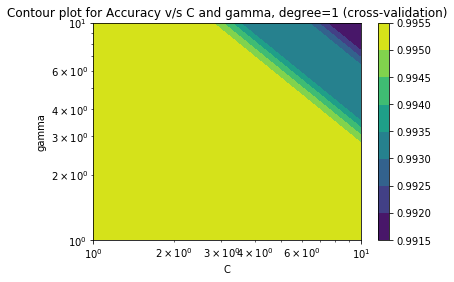

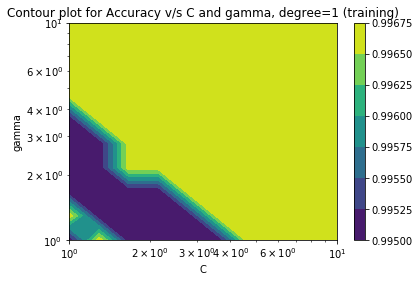

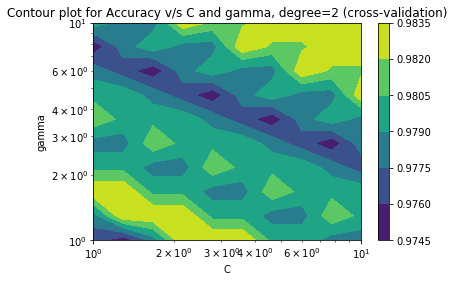

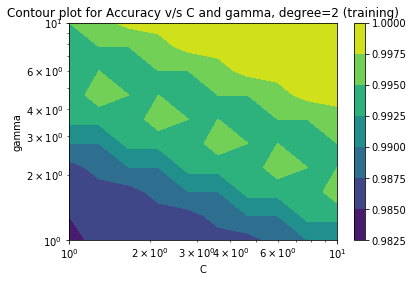

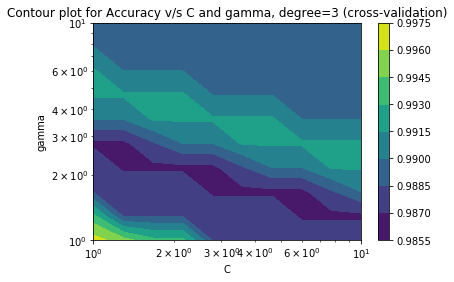

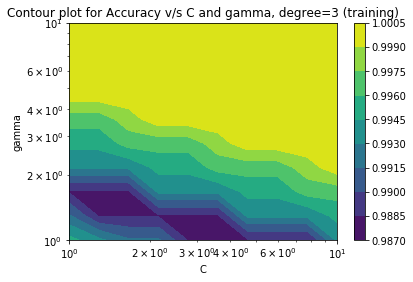

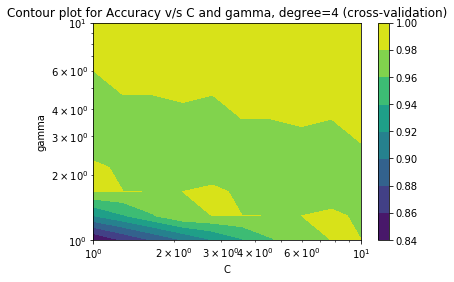

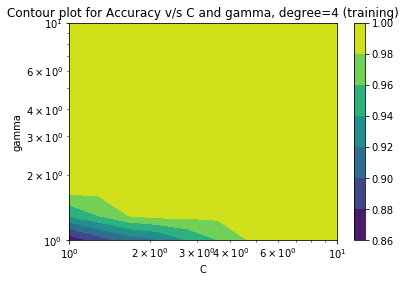

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1.0, 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
sklearn cross-val score: 0.9967, cvxopt cross-val score: 0.9933
sklearn num of SV: 194, cvxopt num of SV: 195
sklearn indices of support vector: [  1   2   3  12  17  19  20  23  26  29  31  33  40  46  49  52  55  60
  61  62  64  66  67  69  73  75  77  82  88  93 101 103 109 113 114 116
 117 120 122 124 129 131 134 136 141 145 148 153 154 156 159 165 166 171
 173 174 175 178 196 197 199 200 202 203 208 210 211 216 217 218 220 224
 228 229 234 235 239 241 244 247 248 255 257 258 259 265 267 272 273 277
 280 282 287 289 292 293 294 295 297 299 302 304 315 323 325 327 337 338
 341 348 349 352 354 356 358 362 372 373 376 378 379 380 381 383 388 389
 390 396 397 399 402 403 406 409 415 418 419 424 426 428 432 436 437 443
 444 446 447 44

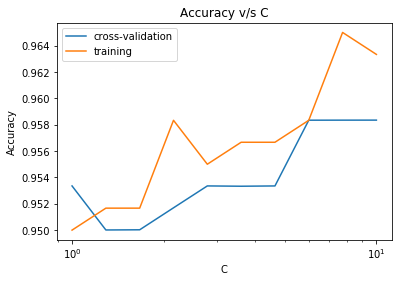

{'C': 10.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 1.0, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
sklearn cross-val score: 0.9583, cvxopt cross-val score: 0.9516
sklearn num of SV: 97, cvxopt num of SV: 99
sklearn indices of support vector: [  7   9  29  34  36  41  47  48  50  62  76  86  88  97  98 108 126 128
 129 136 141 154 159 160 167 170 177 179 182 187 194 198 207 209 214 227
 229 246 247 252 254 257 267 294 300 305 307 309 312 322 326 343 344 347
 357 358 360 372 373 377 384 385 388 389 392 398 407 408 410 425 428 434
 441 449 450 451 462 474 478 520 523 531 535 538 541 545 546 558 560 564
 574 578 580 583 596 597 599]
cvxopt indices of support vector : [  7   9  29  34  36  41  47  48  50  62  74  76  86  88  97  98 108 126
 128 129 136 141 154 159 160 167 170 177 179 182 187 194 198 207 209 214
 227 229 231 246 247 2

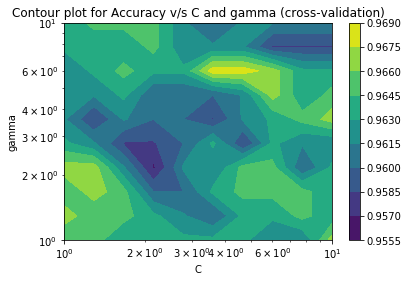

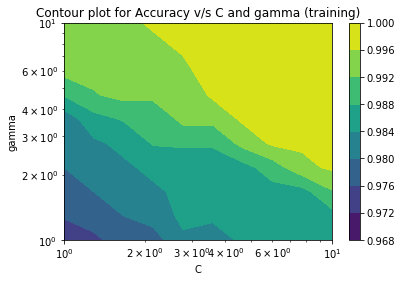

{'C': 3.5938136638046276, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 5.994842503189409, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
sklearn cross-val score: 0.9683, cvxopt cross-val score: 0.9667
sklearn num of SV: 184, cvxopt num of SV: 193
sklearn indices of support vector: [  9  12  13  24  29  34  36  37  41  42  47  48  50  55  57  59  61  62
  65  67  68  71  74  76  82  84  88  90  97 106 108 119 125 126 128 129
 137 141 142 154 159 160 167 170 177 179 182 185 186 187 191 192 194 198
 200 203 207 209 211 212 214 218 221 222 223 224 225 226 227 229 237 239
 245 248 249 252 254 264 271 272 275 279 280 285 290 293 294 295 297 299
 300 306 307 309 310 312 315 322 326 328 336 343 344 346 348 357 358 369
 372 375 378 381 384 388 389 392 394 396 398 399 407 408 410 413 415 419
 422 425 428 434 435 437 441 442 444 449 454 459 466 468 473

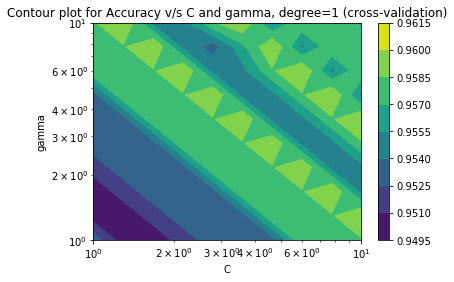

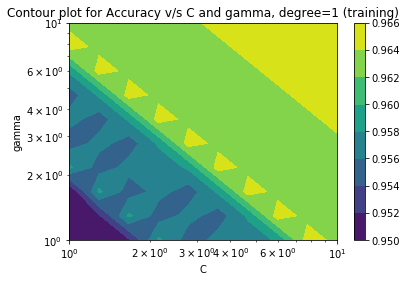

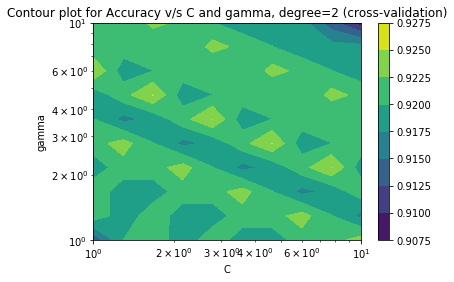

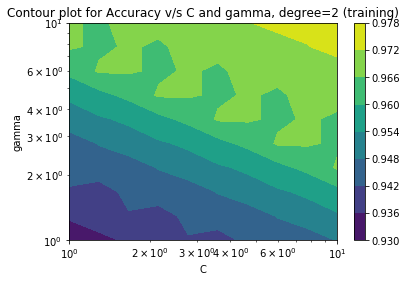

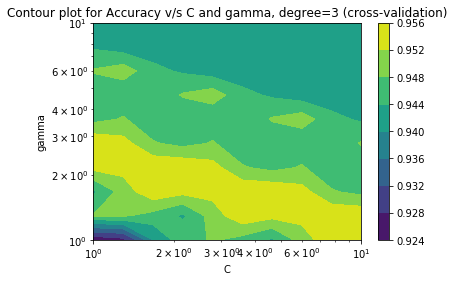

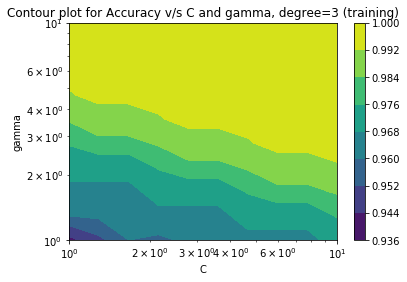

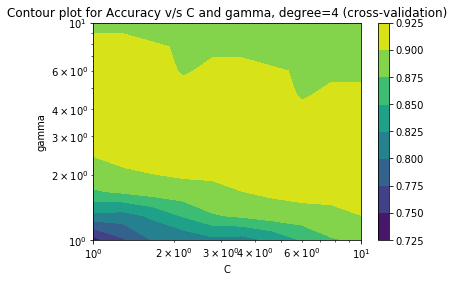

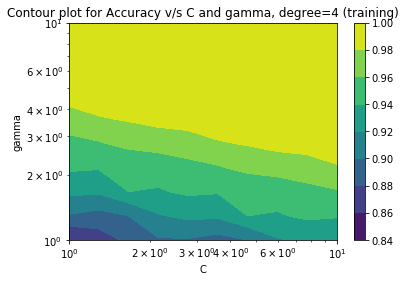

{'C': 1.2915496650148839, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 10.0, 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
sklearn cross-val score: 0.9600, cvxopt cross-val score: 0.9500
sklearn num of SV: 92, cvxopt num of SV: 93
sklearn indices of support vector: [  9  29  34  36  41  47  48  62  76  88  97  98 108 126 128 129 136 141
 154 159 160 167 170 177 179 182 187 194 198 207 209 214 227 229 246 247
 252 254 257 267 294 300 305 307 309 312 322 326 343 344 357 358 360 372
 373 377 384 385 388 389 392 398 407 408 410 425 428 434 441 449 450 451
 462 474 478 520 523 531 535 538 541 545 558 560 564 574 578 580 583 596
 597 599]
cvxopt indices of support vector : [  9  29  34  36  41  47  48  62  76  88  97  98 108 126 128 129 136 141
 154 159 160 167 170 177 179 182 187 194 198 207 209 214 227 229 246 247
 252 254 257 267 294 300 305 

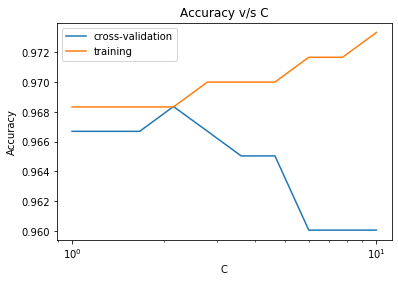

{'C': 2.154434690031884, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 1.0, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
sklearn cross-val score: 0.9684, cvxopt cross-val score: 0.9650
sklearn num of SV: 108, cvxopt num of SV: 108
sklearn indices of support vector: [  1   3   7   9  11  12  19  27  30  34  37  38  45  51  54  62  80  82
  88  98 111 116 123 124 131 137 145 176 178 187 190 196 198 206 215 217
 218 221 226 228 232 234 235 244 253 261 270 272 278 280 305 308 314 334
 335 336 341 353 363 365 374 383 386 387 389 395 396 398 399 403 406 408
 412 421 423 425 432 435 436 440 441 444 451 461 462 464 472 473 483 488
 491 498 499 511 519 532 536 543 549 550 555 556 558 562 577 583 585 594]
cvxopt indices of support vector : [  1   3   7   9  11  12  19  27  30  34  37  38  45  51  54  62  80  82
  88  98 111 116 123 124 131 137 145

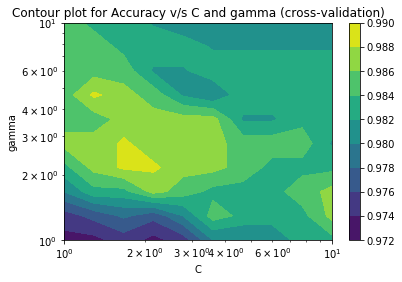

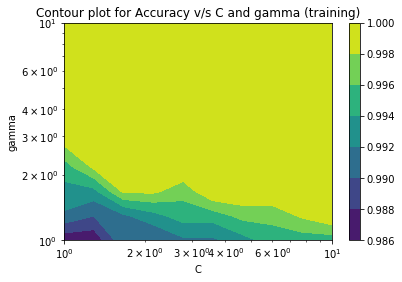

{'C': 1.2915496650148839, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 4.641588833612778, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
sklearn cross-val score: 0.9884, cvxopt cross-val score: 0.9884
sklearn num of SV: 122, cvxopt num of SV: 129
sklearn indices of support vector: [  1   2   8  17  21  22  30  34  37  38  51  55  62  63  80  82  88  89
  93  98 110 111 118 123 124 129 137 140 155 176 188 190 191 196 203 210
 216 217 219 220 221 228 230 234 235 241 246 250 253 258 259 261 266 270
 272 280 297 299 305 307 314 318 321 329 341 342 353 360 363 365 374 376
 377 379 381 384 386 387 389 391 395 396 399 400 403 406 408 412 421 422
 423 425 429 436 438 446 451 462 473 483 486 489 498 499 505 511 519 520
 528 529 532 536 544 549 550 555 556 558 570 577 585 594]
cvxopt indices of support vector : [  1   2   8  17  21  22  30  34  37  38

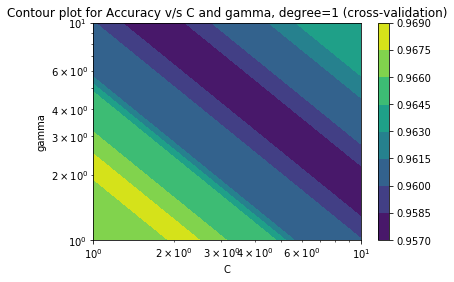

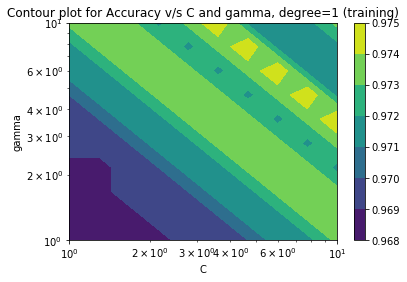

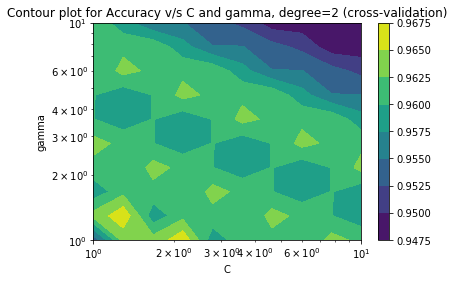

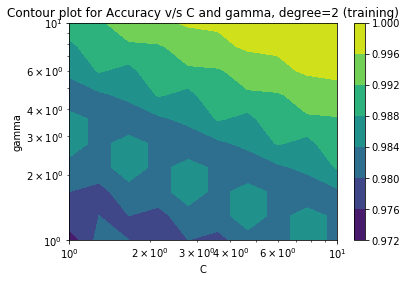

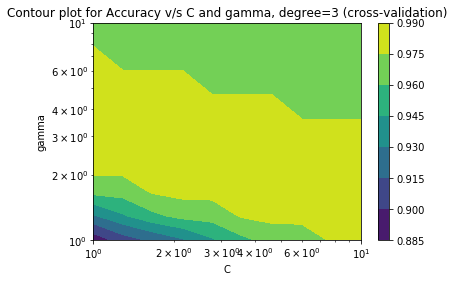

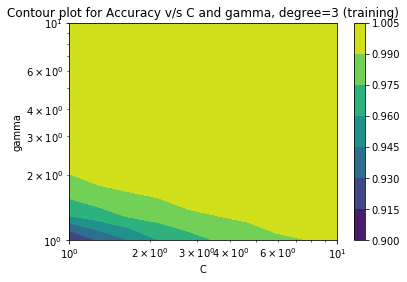

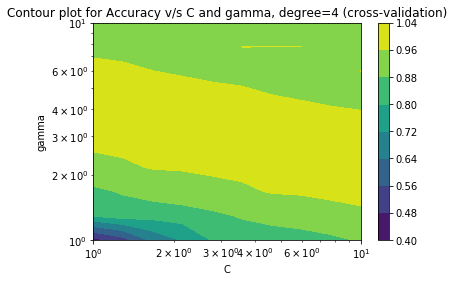

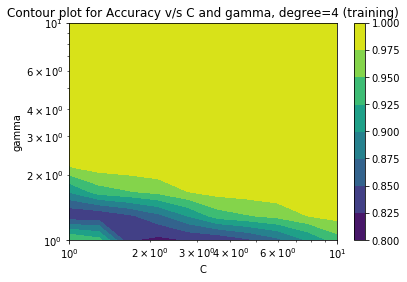

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 2.7825594022071245, 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
sklearn cross-val score: 0.9867, cvxopt cross-val score: 0.9850
sklearn num of SV: 184, cvxopt num of SV: 186
sklearn indices of support vector: [  0   1   3   5   8   9  11  12  19  20  21  22  25  26  28  30  34  36
  37  38  45  49  51  54  61  62  63  64  73  78  80  82  86  88  89  95
  97  98 105 107 111 112 122 123 124 128 130 131 137 145 150 152 157 158
 165 175 176 178 184 188 189 190 192 196 198 199 200 206 208 211 217 219
 221 226 228 232 234 235 236 244 245 247 249 253 254 259 261 266 270 272
 280 284 288 296 299 305 313 314 319 333 334 335 336 342 346 348 353 355
 360 363 364 365 366 373 374 376 379 383 384 386 387 389 391 395 396 400
 401 403 405 406 408 412 417 421 423 425 436 438 440 441 442 445 449 451


In [9]:
# Part 1 (Binary Classification) using 10 features
pairs = [(0, 1), (2, 3), (4, 5)]
for i, j in pairs:
    print('Pair: (%i, %i)'%(i, j))
    idx_i = np.where(t == i)[0]
    idx_j = np.where(t == j)[0]
    idx = np.concatenate((idx_i, idx_j))
    np.random.shuffle(idx)
    Xp = X[idx,:10]
    tp = t[idx]
    tp = np.where(tp==i, -1, 1)
    for kernel in kernels:
        print('Kernel: %s'%(kernel))
        clf_p, cvscore_p = findParameters([kernel], Xp, tp)
        param_p = clf_p.get_params()
        myclf = mysvm(kernel=kernel, C=param_p['C'], gamma=param_p['gamma'], degree=param_p['degree'], coef0=param_p['coef0'])
        mycvscore = crossval_score(myclf, Xp, tp, cv = cv)
        myclf.fit(Xp, tp)
        print(param_p)
        print('sklearn cross-val score: %0.4f, cvxopt cross-val score: %0.4f'%(cvscore_p.mean(), mycvscore.mean()))
        print('sklearn num of SV: %i, cvxopt num of SV: %i'%(clf_p.support_.shape[0], myclf.sv_idx.shape[0]))
        print('sklearn indices of support vector:', np.sort(clf_p.support_))
        print('cvxopt indices of support vector :', myclf.sv_idx)
    print('\n')

Kernel: linear


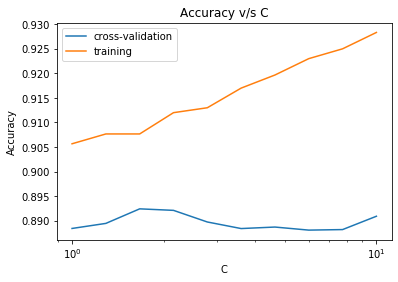

Score: 0.8924 (+/- 0.0349)
{'C': 1.6681005372000588, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 1.0, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Kernel: rbf


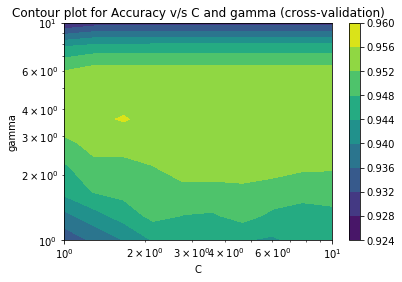

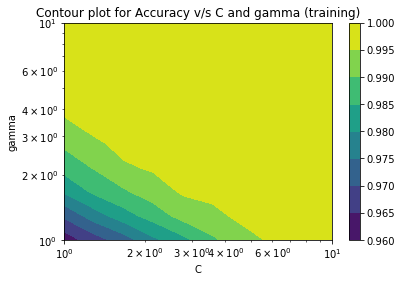

Score: 0.9563 (+/- 0.0156)
{'C': 1.6681005372000588, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 3.5938136638046276, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Kernel: poly


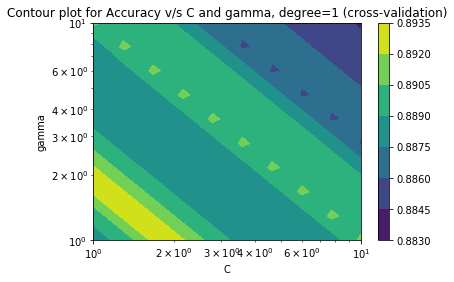

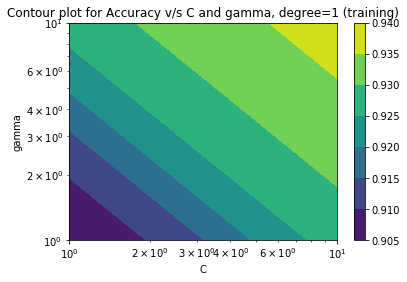

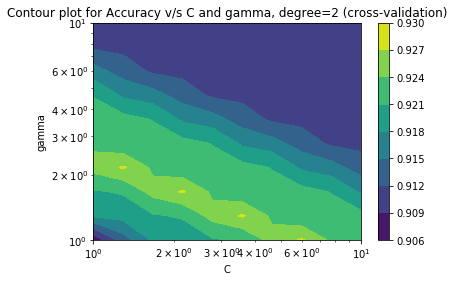

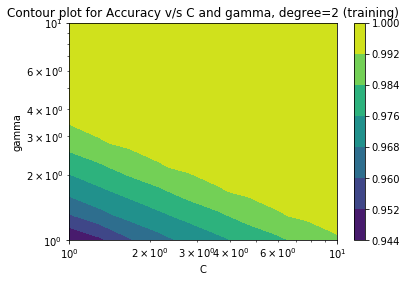

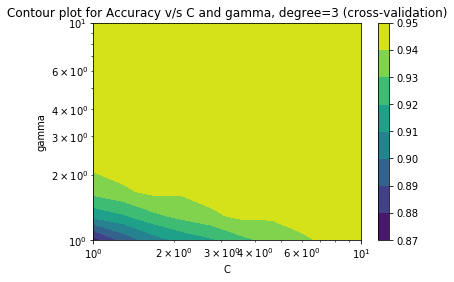

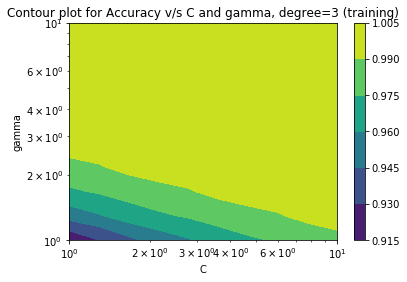

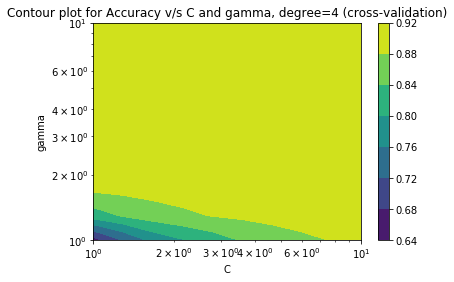

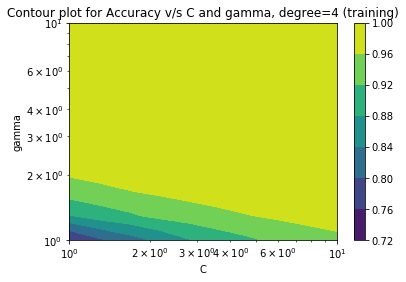

Score: 0.9465 (+/- 0.0122)
{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 2.7825594022071245, 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [10]:
# Part 1 (Multiclass Classification) using all 25 features
for kernel in kernels:
    print('Kernel: %s'%(kernel))
    clf_p1, cvscore_p1 = findParameters([kernel], X, t)
    print("Score: %0.4f (+/- %0.4f)" % (cvscore_p1.mean(), 2*cvscore_p1.std()))
    print(clf_p1.get_params())

Kernel: linear


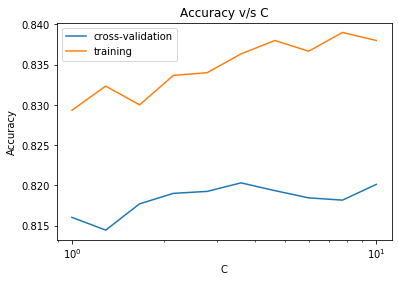

Score: 0.8203 (+/- 0.0409)
{'C': 3.5938136638046276, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 1.0, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Kernel: rbf


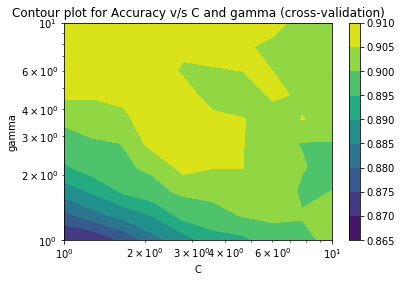

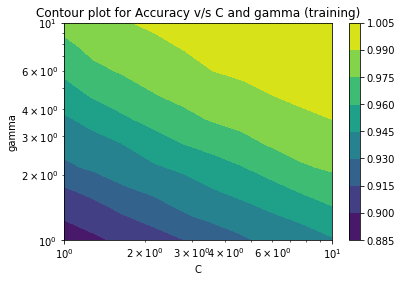

Score: 0.9098 (+/- 0.0308)
{'C': 1.2915496650148839, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 10.0, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Kernel: poly


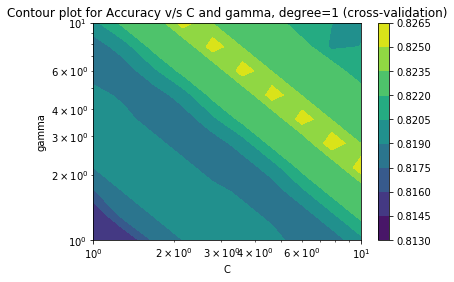

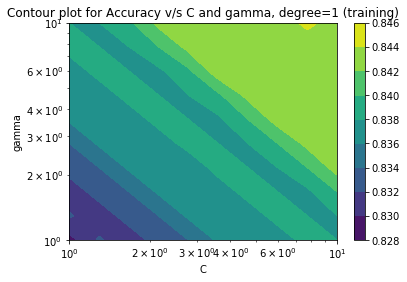

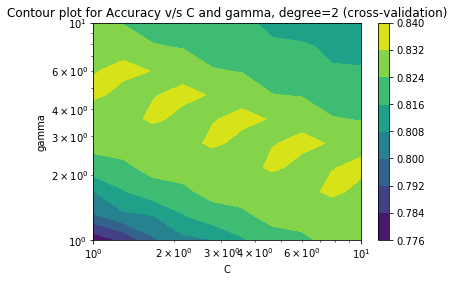

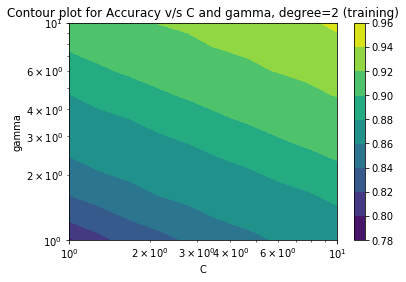

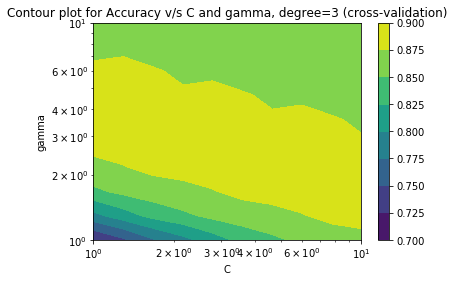

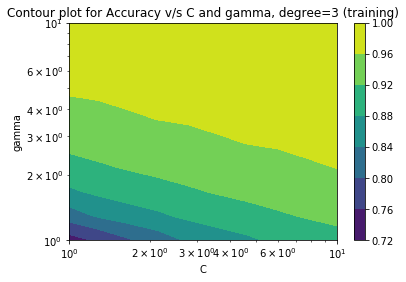

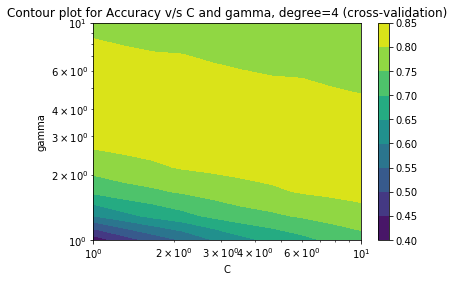

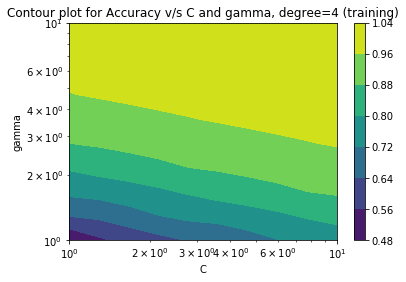

Score: 0.8919 (+/- 0.0236)
{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 3.5938136638046276, 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [11]:
# Part 1 (Multiclass Classification) using 10 features
for kernel in kernels:
    print('Kernel: %s'%(kernel))
    clf_p1, cvscore_p1 = findParameters([kernel], X[:,:10], t)
    print("Score: %0.4f (+/- %0.4f)" % (cvscore_p1.mean(), 2*cvscore_p1.std()))
    print(clf_p1.get_params())

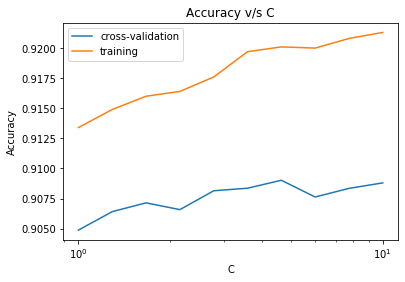

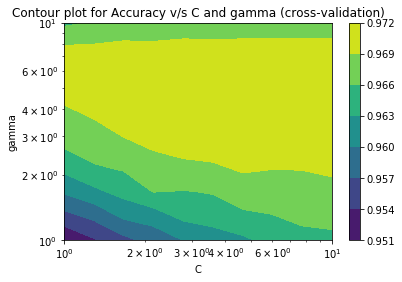

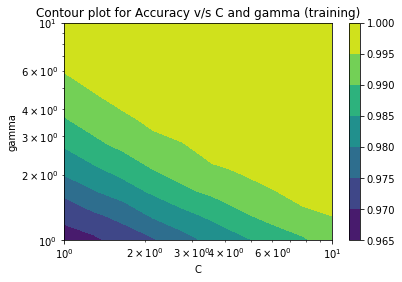

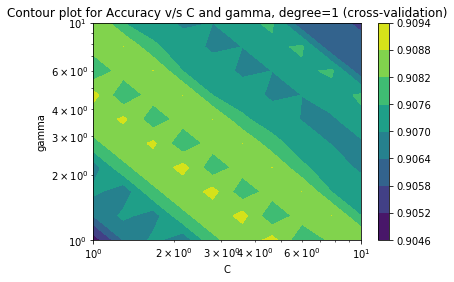

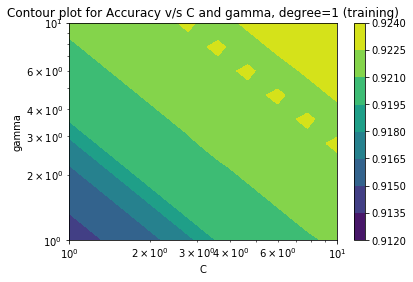

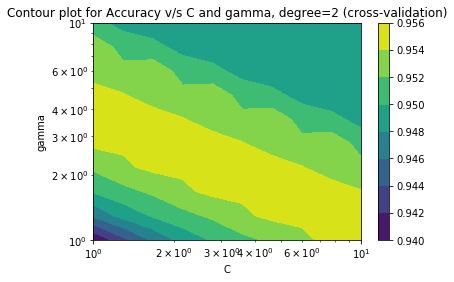

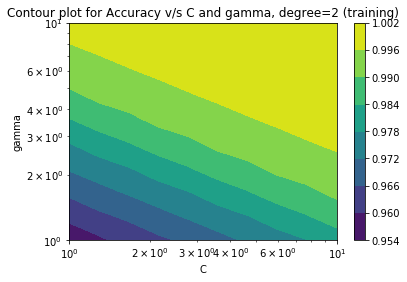

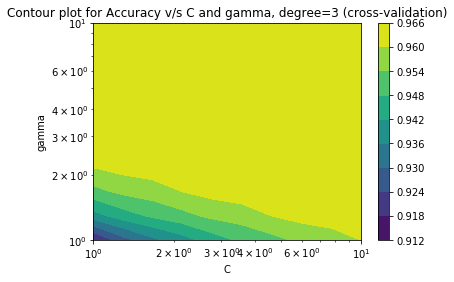

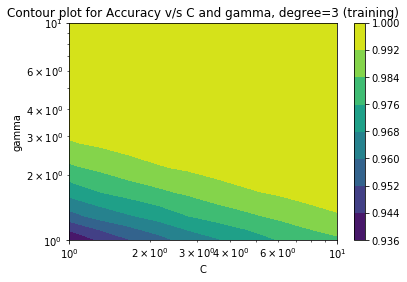

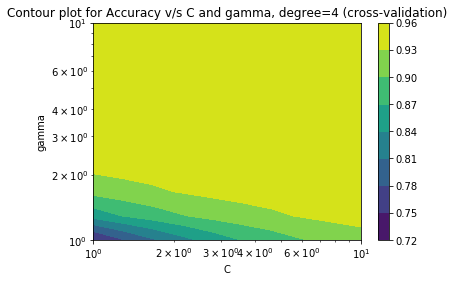

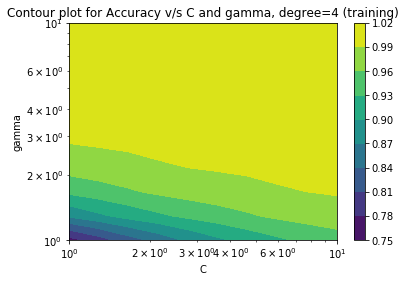

Score: 0.9720 (+/- 0.0078)
{'C': 5.994842503189409, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 4.641588833612778, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [12]:
# Part 2 (training)
clf_p2, cvscore_p2 = findParameters(kernels, train_X, train_t)
print("Score: %0.4f (+/- %0.4f)" % (cvscore_p2.mean(), 2*cvscore_p2.std()))
print(clf_p2.get_params())

In [13]:
# Part 2 (prediction)
prediction_t = clf_p2.predict(prediction_X)
print(prediction_t)
df = pd.DataFrame({'class': prediction_t})
df.to_csv('prediction.csv', index_label = 'id')

[3 5 2 ... 7 2 5]


In [14]:
def kagglePar(X, t):
    beg_c, end_c = 1e-2, 1e2
    for i in range(10):
        c1 = (2*beg_c+end_c)/3
        beg_g, end_g = 1e-2, 1e2
        for j in range(10):
            g1 = (2*beg_g+end_g)/3
            clf = svm.SVC(kernel='rbf', C=c1, gamma = g1)
            scoreg1 = crossval_score(clf, X, t)
            g2 = (beg_g+2*end_g)/3
            clf = svm.SVC(kernel='rbf', C=c1, gamma = g2)
            scoreg2 = crossval_score(clf, X, t)
            if scoreg1.mean() < scoreg2.mean():
                beg_g = g1
            else:
                end_g = g2
        g1 = (beg_g+end_g)/2
        clf = svm.SVC(kernel='rbf', C=c1, gamma=g1)
        scorec1 = crossval_score(clf, X, t)
        
        c2 = (2*beg_c+end_c)/3
        beg_g, end_g = 1e-5, 1e5
        for j in range(10):
            g1 = (2*beg_g+end_g)/3
            clf = svm.SVC(kernel='rbf', C=c2, gamma = g1)
            scoreg1 = crossval_score(clf, X, t)
            g2 = (beg_g+2*end_g)/3
            clf = svm.SVC(kernel='rbf', C=c2, gamma = g2)
            scoreg2 = crossval_score(clf, X, t)
            if scoreg1.mean() < scoreg2.mean():
                beg_g = g1
            else:
                end_g = g2
        g2 = (beg_g+end_g)/2
        clf = svm.SVC(kernel='rbf', C=c2, gamma=g2)
        scorec2 = crossval_score(clf, X, t)
        if scorec1.mean() < scorec2.mean():
            beg_c = c1
        else:
            end_c = c2
    
    c = (beg_c+end_c)/2;
    for j in range(10):
        g1 = (2*beg_g+end_g)/3
        clf = svm.SVC(kernel='rbf', C=c, gamma = g1)
        scoreg1 = crossval_score(clf, X, t)
        g2 = (beg_g+2*end_g)/3
        clf = svm.SVC(kernel='rbf', C=c, gamma = g2)
        scoreg2 = crossval_score(clf, X, t)
        if scoreg1.mean() < scoreg2.mean():
            beg_g = g1
        else:
            end_g = g2
    g = (beg_g+end_g)/2
    clf = svm.SVC(kernel='rbf', C=c, gamma=g)
    score = crossval_score(clf, X, t)
    return clf, score

In [15]:
# Further Training - Improving score on Kaggle
clf_k, score_k = kagglePar(train_X, train_t)
print("Score: %0.4f (+/- %0.4f)" % (score_k.mean(), 2*score_k.std()))
print(clf_k.get_params())

Score: 0.1296 (+/- 0.0129)
{'C': 0.010846669714982472, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 15.03644298958223, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
